In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from yellowbrick.cluster import SilhouetteVisualizer
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture


## Process data

In [2]:
# Import data
DIR = "../../data/"
sub = "Subway USA/"
demographic = pd.read_csv(DIR + sub + "processed_demographic.csv")
stores = pd.read_csv(DIR + sub + "subway_usa_stores.csv", encoding='latin-1')
poi_variables = pd.read_csv(DIR + sub + "processed_poi.csv")
trade_area = pd.read_csv(DIR + sub + "processed_trade_area.csv")

# Merge data
merged = stores.merge(
    poi_variables, on="store"
).merge(
    trade_area, on="store"
)

# set store as index
merged.set_index("store", inplace=True)

# drop columns
merged = merged.drop(columns=["longitude", "latitude", "cbsa_name", "dma_name", "censusregion", "censusdivision"])
# merged

In [3]:
ordinal_features_oth = [
    "market_size",
    "store_density",
]
ordering_ordinal_oth = [
    ["Very Large Metro (1)", "Large Metro (2)", "Large City (3)", "Medium City (4)", "Small City (5)", "Small Town (6)", "Small Community (7)", ""],
    ["Rural", "Exurban", "Suburban", "Light Suburban", "Light Urban", "Urban", "Super Urban"],
]
numeric_features = list(set(merged.select_dtypes(include=np.number).columns.tolist()))

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer_oth, ordinal_features_oth),
)

In [4]:
preprocessor.fit(merged)
transformed = preprocessor.transform(merged)

column_names = (
    numeric_features
    + ["market_size", "store_density"]
)
# number of features
len(column_names)

220

In [5]:
transformed_df = pd.DataFrame(transformed, columns=column_names)
# transformed_df

In [6]:
column_names.sort()
# column_names

## Kmeans

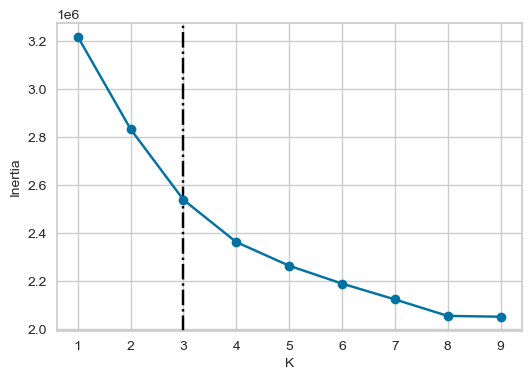

In [7]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(transformed_df).inertia_)
plot_elbow(6, 4, inertia_values)

In [8]:
k = 3
km = KMeans(n_clusters=k, n_init='auto', random_state=42)
km.fit(transformed_df)

cluster_labels = km.labels_
counts = np.bincount(cluster_labels)
total_count = len(cluster_labels)
percentages = (counts / total_count) * 100

for number, percentage in enumerate(percentages, start=1):
    print("{}: {:.2f}%".format(number, percentage))

1: 1.88%
2: 48.82%
3: 49.30%


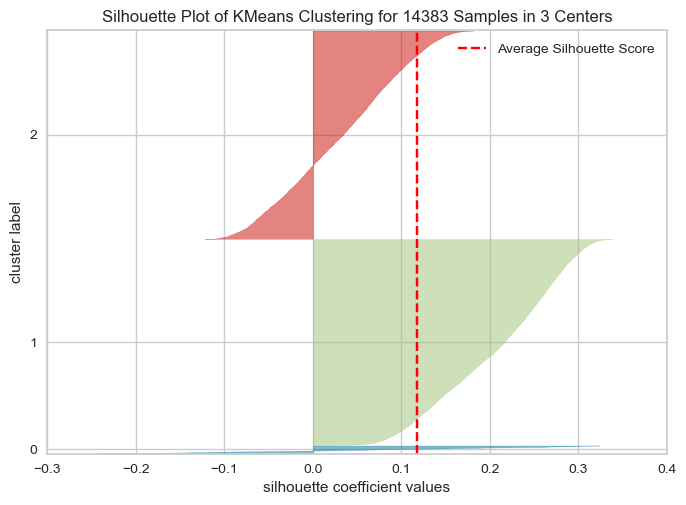

In [9]:
model = KMeans(k, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(transformed_df)
visualizer.show();

## DBSCAN

## PCA

In [10]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=50)

# reduced_data = pca.fit_transform(transformed_df)

# print("Explained variance ratio:", sum(pca.explained_variance_ratio_))

In [11]:
# try DBSCAN
for eps in range(10, 15):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(transformed_df)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=10
Number of clusters: 31
Cluster sizes: [ 2292 11895     9     8     6     6     9     8    11     6     6     8
     6     6     6     7     9     9     5    17     4     3     7     4
     5     6     5     7     3     5     5]

eps=11
Number of clusters: 24
Cluster sizes: [ 1368 12857     7     8    10     7     8     4    11     9     6    15
     6     6    13     4     7     5     5     9     5     4     5     4]

eps=12
Number of clusters: 17
Cluster sizes: [  881 13383     5     8     9    11    15    17    10     7     9     5
     4     5     4     5     5]

eps=13
Number of clusters: 14
Cluster sizes: [  567 13702     8     9    15     5     9     7    18     6     7    11
     5    14]

eps=14
Number of clusters: 17
Cluster sizes: [  347 13884     8    12     9    21     6     5    23     6     7    25
     7     7     5     7     4]


## hdbscan

In [12]:
min_cluster_size_values = [5, 10, 15]
min_samples_values = [1, 2, 3]

for min_cluster_size in min_cluster_size_values:
    for min_samples in min_samples_values:
        print("min_cluster_size={}, min_samples={}".format(min_cluster_size, min_samples))
        
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                            min_samples=min_samples)
        
        labels = hdbscan_clusterer.fit_predict(transformed_df)
        
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        cluster_sizes = [list(labels).count(i) for i in range(num_clusters)]
        print("Number of clusters:", num_clusters)
        print("Cluster sizes:", cluster_sizes)
        print()

min_cluster_size=5, min_samples=1
Number of clusters: 4
Cluster sizes: [6, 35, 14314, 6]

min_cluster_size=5, min_samples=2
Number of clusters: 4
Cluster sizes: [6, 35, 14305, 5]

min_cluster_size=5, min_samples=3
Number of clusters: 3
Cluster sizes: [6, 14327, 35]

min_cluster_size=10, min_samples=1
Number of clusters: 2
Cluster sizes: [14333, 35]

min_cluster_size=10, min_samples=2
Number of clusters: 2
Cluster sizes: [14329, 35]

min_cluster_size=10, min_samples=3
Number of clusters: 2
Cluster sizes: [14327, 35]

min_cluster_size=15, min_samples=1
Number of clusters: 2
Cluster sizes: [14333, 35]

min_cluster_size=15, min_samples=2
Number of clusters: 2
Cluster sizes: [14329, 35]

min_cluster_size=15, min_samples=3
Number of clusters: 2
Cluster sizes: [14327, 35]



## FCM

In [13]:
# hyperparameter tune
k_values = [3, 4, 5, 6, 7, 8, 9, 10]
m_values = [1.2, 1.5, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0]

best_score = -1
best_k = None
best_m = None

# Grid search over K and m
for k in k_values:
    for m in m_values:
        # FCM
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            transformed_df.T, k, m, error=0.005, maxiter=1000, init=None, seed=42
        )
        
        # cluster labels
        cluster_membership = np.argmax(u, axis=0)
        
        # Calculate silhouette score
        score = silhouette_score(transformed_df, cluster_membership)
        
        # best score
        if score > best_score:
            best_score = score
            best_k = k
            best_m = m

# Print the best parameters and Silhouette score
print("Best Parameters:")
print("K:", best_k)
print("m:", best_m)
print("Best Silhouette Score:", best_score)

Best Parameters:
K: 4
m: 1.2
Best Silhouette Score: 0.11068649692474058


In [14]:
# the number of clusters (K) and the fuzziness parameter (m)
# (increases the fuzziness and allows for more overlapping clusters)
n_clusters = best_k
m = best_m

# FCM
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    transformed_df.T, n_clusters, m, error=0.005, maxiter=1000, init=None, seed=42
)

# cluster labels
cluster_membership = np.argmax(u, axis=0)

In [15]:
# Calculate the cluster percentages
cluster_percentages = []
for cluster in range(n_clusters):
    percentage = np.sum(cluster_membership == cluster) / len(cluster_membership) * 100
    cluster_percentages.append(percentage)

# Print the cluster percentages
for cluster, percentage in enumerate(cluster_percentages):
    print(f"Cluster {cluster + 1} Percentage: {percentage:.2f}%")

Cluster 1 Percentage: 38.71%
Cluster 2 Percentage: 28.94%
Cluster 3 Percentage: 30.57%
Cluster 4 Percentage: 1.79%


In [16]:
# Select 5 random samples from each cluster
random_samples = []
for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_membership == cluster)[0]
    cluster_samples = np.random.choice(cluster_indices, size=5, replace=False)
    random_samples.extend(cluster_samples)

# Print the randomly selected samples
print("Randomly Selected Samples:")
for sample_index in random_samples:
    cluster = cluster_membership[sample_index]
    sample_store = transformed_df.index[sample_index]
    print(f"Store: {sample_store}, Cluster: {cluster}")

Randomly Selected Samples:
Store: 11729, Cluster: 0
Store: 11569, Cluster: 0
Store: 14236, Cluster: 0
Store: 2743, Cluster: 0
Store: 7993, Cluster: 0
Store: 5720, Cluster: 1
Store: 13738, Cluster: 1
Store: 275, Cluster: 1
Store: 4051, Cluster: 1
Store: 4503, Cluster: 1
Store: 5635, Cluster: 2
Store: 3771, Cluster: 2
Store: 12603, Cluster: 2
Store: 5947, Cluster: 2
Store: 13126, Cluster: 2
Store: 11096, Cluster: 3
Store: 6038, Cluster: 3
Store: 5615, Cluster: 3
Store: 10170, Cluster: 3
Store: 5276, Cluster: 3


## GMM

The Silhouette Score ranges from -1 to 1, where a higher score indicates better clustering structure. A score close to 1 suggests well-separated clusters, while a score close to -1 indicates that samples might have been assigned to the wrong clusters.



The calinski_harabasz_score() function calculates the Calinski-Harabasz Index, which measures the ratio between the within-cluster dispersion and between-cluster dispersion. Higher values indicate better-defined and more separated clusters.


The davies_bouldin_score() function calculates the Davies-Bouldin Index, which evaluates the average similarity between each cluster and its most similar cluster, taking into account both the within-cluster and between-cluster distances. Lower values indicate better clustering results.

In [25]:
# tune
k_values = [3, 4, 5, 6, 7, 8, 9, 10]
covariance_types = ['full', 'tied', 'diag', 'spherical']
reg_params = [0.001, 0.01, 0.1, 1, 10, 100]

best_score = 999999
best_k = None
best_covariance_type = None
best_reg_param = None

# Grid search
for k in k_values:
    for covariance_type in covariance_types:
        for reg_param in reg_params:
            # GMM
            gmm = GaussianMixture(n_components=k, covariance_type=covariance_type,
                                  reg_covar=reg_param, random_state=42)
            gmm.fit(transformed_df)
            
            # cluster labels
            cluster_membership = gmm.predict(transformed_df)
            
            # silhouette score
            # score = silhouette_score(transformed_df, cluster_membership)
            # Calculate Calinski-Harabasz Index
            # score = calinski_harabasz_score(transformed_df, cluster_membership)
            # Calculate Davies-Bouldin Index
            score = davies_bouldin_score(transformed_df, cluster_membership)

            # best
            if score < best_score:
                best_score = score
                best_k = k
                best_covariance_type = covariance_type
                best_reg_param = reg_param

/Users/morris/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/morris/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/morris/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/morris/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate

In [27]:
# Print the best hyperparameters and score
print("Best Hyperparameters:")
print("K:", best_k)
print("Covariance Type:", best_covariance_type)
print("Regularization Parameter:", best_reg_param)
print("Best Score:", best_score)

Best Hyperparameters:
K: 3
Covariance Type: spherical
Regularization Parameter: 100
Best Score: 0.5944680733300682


In [32]:
# best GMM
best_gmm = GaussianMixture(n_components=5, 
                           covariance_type="full",
                           reg_covar=0.1,
                           random_state=42)
best_gmm.fit(transformed_df)

# cluster labels
cluster_membership = best_gmm.predict(transformed_df)

# cluster percentages
cluster_percentages = []
for cluster in range(5):
    percentage = np.sum(cluster_membership == cluster) / len(cluster_membership) * 100
    cluster_percentages.append(percentage)

# cluster percentages
for cluster, percentage in enumerate(cluster_percentages):
    print(f"Cluster {cluster + 1} Percentage: {percentage:.2f}%")

Cluster 1 Percentage: 7.60%
Cluster 2 Percentage: 33.62%
Cluster 3 Percentage: 10.82%
Cluster 4 Percentage: 46.57%
Cluster 5 Percentage: 1.39%


In [33]:
# Get the cluster labels
cluster_membership = best_gmm.predict(transformed_df)

# Select 5 random samples from each cluster
random_samples = []
for cluster in range(best_k):
    cluster_indices = np.where(cluster_membership == cluster)[0]
    cluster_samples = np.random.choice(cluster_indices, size=5, replace=False)
    random_samples.extend(cluster_samples)

# Print the randomly selected samples and their cluster information
print("Randomly Selected Samples:")
for sample_index in random_samples:
    cluster = cluster_membership[sample_index]
    sample_store = transformed_df.index[sample_index]
    print(f"Store: {sample_store}, Cluster: {cluster}")

Randomly Selected Samples:
Store: 5266, Cluster: 0
Store: 5512, Cluster: 0
Store: 5582, Cluster: 0
Store: 5386, Cluster: 0
Store: 3203, Cluster: 0
Store: 1703, Cluster: 1
Store: 2899, Cluster: 1
Store: 11908, Cluster: 1
Store: 12561, Cluster: 1
Store: 4227, Cluster: 1
Store: 9554, Cluster: 2
Store: 82, Cluster: 2
Store: 954, Cluster: 2
Store: 6203, Cluster: 2
Store: 3678, Cluster: 2


## AgglomerativeClustering

In [34]:
from sklearn.cluster import AgglomerativeClustering

# Define the number of clusters (K)
n_clusters = 4

# Initialize and fit the Agglomerative Clustering model
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative.fit(transformed_df)

# Get the cluster labels
cluster_labels = agglomerative.labels_

In [35]:
# Calculate the cluster percentages
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
total_samples = len(cluster_labels)
cluster_percentages = cluster_counts / total_samples * 100

# Print the cluster percentages
print("Cluster Percentages:")
for cluster, percentage in zip(unique_clusters, cluster_percentages):
    print(f"Cluster {cluster + 1}: {percentage:.2f}%")

print("\n")
# Select 5 random samples from each cluster
random_samples = []
for cluster in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) >= 5:
        cluster_samples = np.random.choice(cluster_indices, size=5, replace=False)
    else:
        cluster_samples = cluster_indices
    random_samples.extend(cluster_samples)

# Print the randomly selected samples and their cluster information
print("Randomly Selected Samples:")
for sample_index in random_samples:
    cluster = cluster_labels[sample_index]
    sample_store = transformed_df.index[sample_index]
    print(f"Store: {sample_store}, Cluster: {cluster + 1}")

print("\n")
# Print the silhouette score
print("Silhouette Score:", silhouette_score(transformed_df, cluster_labels))

Cluster Percentages:
Cluster 1: 3.75%
Cluster 2: 39.25%
Cluster 3: 31.47%
Cluster 4: 25.54%


Randomly Selected Samples:
Store: 5126, Cluster: 1
Store: 2688, Cluster: 1
Store: 9901, Cluster: 1
Store: 12557, Cluster: 1
Store: 5615, Cluster: 1
Store: 1332, Cluster: 2
Store: 13731, Cluster: 2
Store: 3966, Cluster: 2
Store: 9405, Cluster: 2
Store: 13632, Cluster: 2
Store: 1235, Cluster: 3
Store: 12746, Cluster: 3
Store: 9309, Cluster: 3
Store: 5784, Cluster: 3
Store: 4028, Cluster: 3
Store: 13211, Cluster: 4
Store: 6134, Cluster: 4
Store: 9328, Cluster: 4
Store: 7621, Cluster: 4
Store: 7031, Cluster: 4


Silhouette Score: 0.06475416408344759
